# Read QChem output file

In [1]:
# import for plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Functions

In [2]:
import re
import numpy as np
def MDStep(file_name):
    # Some regex expressions
    num_str = re.compile('[+-]?\d+\.?\d*') # to find numbers
    time=re.compile(r'Time\s\(fs\)\s+(\d+\.\d+)')
    findforce=re.compile(r'Forces \(Hartrees\/Bohr\)')
    timestep = re.compile(r'TIME STEP #(\d+)\s\(t = (d\.\d+)\sa.u.\s=\s(d+\.\d+)')
    coord=re.compile(r'X=\s+([-]?\d\.\d+)D([+-]+\d+)\sY=\s+([-]?\d\.\d+)D([+-]+\d+)\sZ=\s+([-]?\d\.\d+)D([+-]+\d+)')
    endcoord=re.compile(r'MW cartesian velocity\:')
    #######
    temp = []
    time = []
    energy = []
    crd = [] # store coordinates in 2D array
    atoms = []
    s = 1.0
    step = 0
    startdyn = 0
    with open(file_name, 'r') as Qfile:
        data=Qfile.readlines()
    for i in range(len(data)):
        # TIME STEP #1 (t = 0.000 a.u. = 0.00000 fs)
        if i==8:
             print(i,data[i])
        if re.search(r'TIME STEP #',data[i]):
            fsec = float(re.findall(r'=\s(\d+\.\d+)\sfs',data[i])[0])
            time.append(fsec)
            startdyn = 1
            # Instantaneous Temperature = 291.9 K
        if re.search(r'Instantaneous Temperature =',data[i]):
            temperature = float(re.findall(r'=\s(\d+\.\d+)\sK',data[i])[0])
            temp.append(temperature)
            i+=1 # Move forward to coordinates
            #    1      O       1.3875858765     0.0114645102     0.1090411228
            #    2      H       1.7395762231     0.7248323964    -0.4529874171
            #    3      H       1.7383622270    -0.7920238234    -0.2840530212
            cols = []
            a = []
            i+=4 # skip forward to geometry
            while re.search(r'----',data[i]) is None: 
                atom = re.findall(r'\s([A-Z])\s',data[i])
                a.append(atom)
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:3]))))                
                i+=1
            crd.append(cols)
            atoms.append(a)
        ## Find energy
        if re.search(r'Total energy in the final basis set = ',data[i]):
            total_energy = float(re.findall(r'=\s+([-]?\d+\.\d+)',data[i])[0])
            energy.append(total_energy) 
    print("Completed read of file\n Coordinates, time(fsec), temperature(K), energy(Hartree) returned...")
    
    sR = np.array(crd)
    energy = energy[1:]
    return sR,time,temp,energy,atoms

### extended xyz format write 
File to be used for training of sGDML 
<div class="alert alert-block alert-info"> Below is an example of an extended xyz file:
</div>
<code>
9
-97088.53328354699
C	-0.019177078255	0.565281506616	-0.017707166769	0.00  0.00 0.00
C	-1.322541010044	-0.257863017132	0.021104784603	0.00  0.00 0.00
O	1.20740778407	-0.240470008061	0.052343885974	0.00  0.00 0.00
H	0.112915342493	1.272309700543	-0.830045235762	0.00  0.00 0.00
H	0.158814392784	1.116626422051	0.869682199341	0.00  0.00 0.00
H	-1.087634829566	-1.149513478699	0.663030580516	0.00  0.00 0.00
H	-2.2950373724	0.282895316258	0.198602896473	0.00  0.00 0.00
H	-1.305725447355	-0.565837176562	-1.040260047316	0.00  0.00 0.00
H	1.229837602444	-0.800426536788	-0.732200699668	0.00  0.00 0.00
</code>


In [70]:
def write_exyz(atoms,energy,coord,filename):
    numatoms = np.shape(atoms)[1]
    numsteps = np.shape(atoms)[0]
    f  = open(filename,'w')
    for i in np.arange(numsteps):
        f.write(str(numatoms)+"\n")
        f.write(str(energy[i])+"\n")
        for j in np.arange(numatoms):
            geom = '{0:9.6f} {1:9.6f} {2:9.6f} '.format(coord[i][j][0],coord[i][j][1],coord[i][j][2])
            geom_line = atoms[i][j][0]+"  "+geom+" 0.0000 0.0000 0.0000\n"
            f.write(geom_line)
    return   

## Data Analysis

In [125]:
filename='qchem_test.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [126]:
atoms

[[['O'], ['H'], ['H'], ['O'], ['H'], ['H']],
 [['O'], ['H'], ['H'], ['O'], ['H'], ['H']],
 [['O'], ['H'], ['H'], ['O'], ['H'], ['H']],
 [['O'], ['H'], ['H'], ['O'], ['H'], ['H']],
 [['O'], ['H'], ['H'], ['O'], ['H'], ['H']],
 [['O'], ['H'], ['H'], ['O'], ['H'], ['H']]]

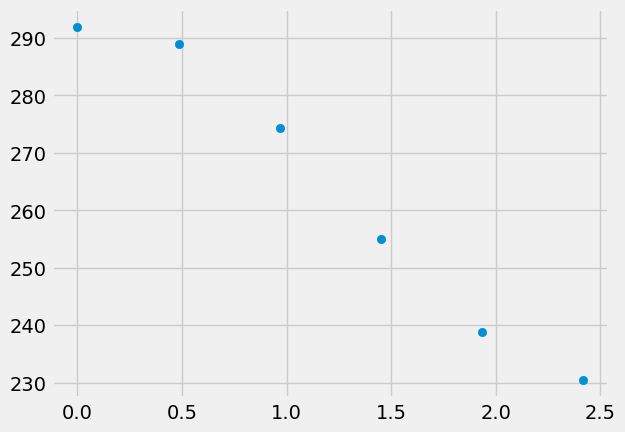

In [108]:
plt.scatter(time,temp)

In [133]:
filename='QChem_waterdimer_output192201.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [134]:
np.shape(energy)

(1000,)

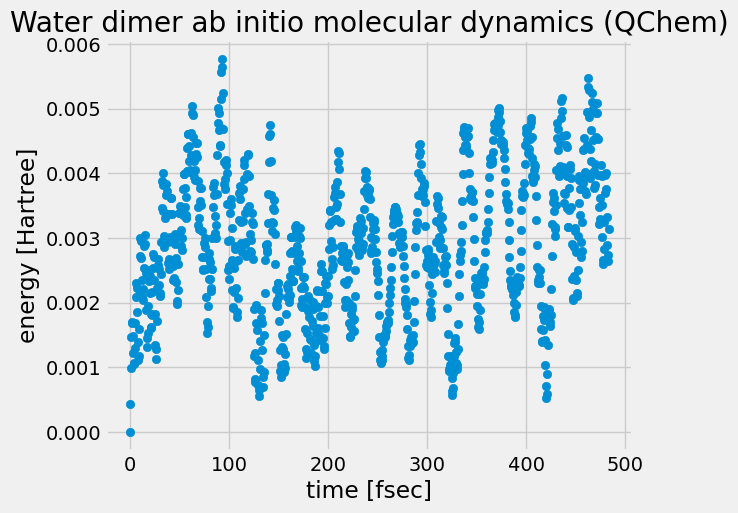

In [135]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Water dimer ab initio molecular dynamics (QChem)")
plt.savefig("energy_water_dimer.png",dpi=300, bbox_inches = "tight")

In [48]:
filename='output192979.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


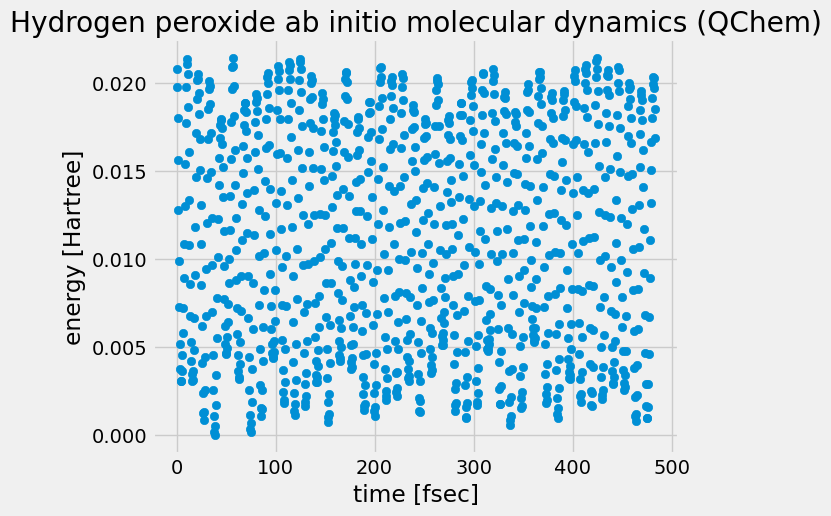

In [49]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Hydrogen peroxide ab initio molecular dynamics (QChem)")
plt.savefig("energy_peroxide.png",dpi=300, bbox_inches = "tight")

In [63]:
filename = "syn-MVK-oxide-aims.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [71]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo.xyz")

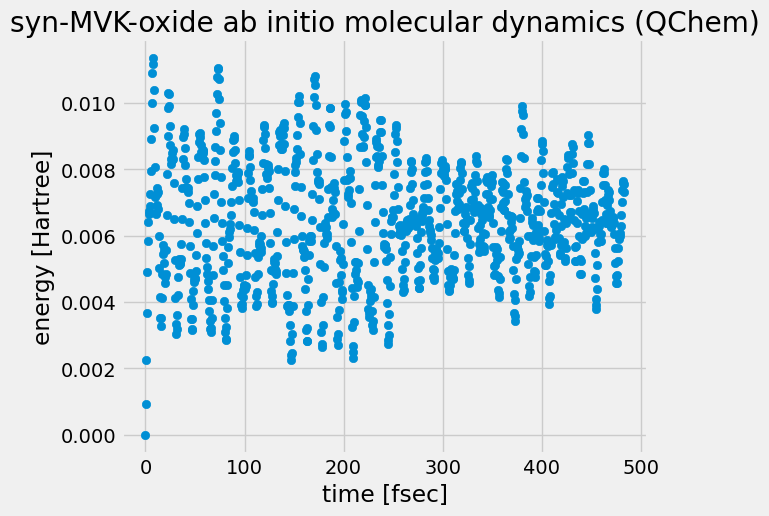

In [16]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem)")
plt.savefig("syn-MVK-oxide.png",dpi=300, bbox_inches = "tight")